In [2]:
from scipy.io import netcdf
import numpy as np
from pylab import clf, plot, show, floor, ceil, imshow
import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline
#xlabel, ylabel, legend, savefig, colorbar, title, clim, pcolor, cm, contourf
import os
import csv
import sys
import glob
from netCDF4 import Dataset

from IPython.display import display, Math, Latex, Image
from mpl_toolkits.basemap import Basemap
import mpl_toolkits
from mpl_toolkits.axes_grid1 import make_axes_locatable

sys.path.append('/noc/users/am8e13/PyNGL-1.4.0/lib/python2.7/site-packages/PyNGL/')
import Ngl
sys.path.append('/noc/users/am8e13/Python/')
import komod
sys.path.append('/noc/users/am8e13/Python/PyNIO-1.4.0/')
import Nio

sys.path.append('/noc/users/am8e13/Python/')
from python_functions import *
import cmocean
import random
import calendar

from IPython.html.widgets import interact, interactive
from IPython.display import clear_output, display, HTML

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 30 days
:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [3]:
woa = Woa()
#grid = grid_read(36)
grid = grid_read(18)

/noc/users/am8e13/anaconda/lib/python2.7/site-packages/scipy/io/netcdf.py:287: RuntimeWarning: Cannot close a netcdf_file opened with mmap=True, when netcdf_variables or arrays referring to its data still exist. All data arrays obtained from such files refer directly to data on disk, and must be copied before the file can be cleanly closed. (See netcdf_file docstring for more information on mmap.)
  ), category=RuntimeWarning)
/noc/users/am8e13/anaconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:598: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


In [4]:
times = range(0,60,1)+range(61,61+60,1)
pert_bench_18 = RunRead()
pert_bench_18.getPath('/hpcdata/scratch/am8e13/arctic420x384/experiments/exp_bench/results/')
pert_bench_18.title('No restoring','blue')
pert_bench_18.readStateData(times)
pert_bench_18.readMonitorData([6220800,6480000])
pert_bench_18.readMonitorSeaiceData([6220800,6480000])
pert_bench_18.readDynStData(11,[6220800,6480000])
#pert_bench_18.readTracers(range(0,75,12))
#pert_bench_18.readLayers(range(0,75,12))
pert_bench_18.seaiceread(range(0,75,1))
pert_bench_18.mxldepthread(range(0,120*3,1))
pert_bench_18.fluxCalc()
pert_bench_18.baroCalc()
pert_bench_18.saveflux('exp_benchmark')
pert_bench_18.savepsi('exp_benchmark')
#pert_bench.read_flux('exp_benchmark')
#pert_bench.read_psi('exp_benchmark')
#pert_bench.readDynStDiagLayers([6220800,6480000])
#pert_bench.readDynStDiagPtracers([6220800,6480000])

Data read from /hpcdata/scratch/am8e13/arctic420x384/experiments/exp_bench/results/
Read Monitor
Read Seaice Monitor
Read StDyn data
Read seaice

/noc/users/am8e13/anaconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:319: RuntimeWarning: All-NaN slice encountered
  warnings.warn("All-NaN slice encountered", RuntimeWarning)
/noc/users/am8e13/anaconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:220: RuntimeWarning: All-NaN axis encountered
  warnings.warn("All-NaN axis encountered", RuntimeWarning)



Read Mxldepth


In [5]:
times = range(0,60,1)+range(61,61+60,1)
pert_const_18 = RunRead()
pert_const_18.getPath('/hpcdata/scratch/am8e13/arctic420x384/experiments/exp_const/results/')
pert_const_18.readStateData(times)
pert_const_18.title('Const restoring','red')
pert_const_18.readMonitorData([6220800,6480000])
pert_const_18.readMonitorSeaiceData([6220800,6480000])
pert_const_18.readDynStData(11,[6220800,6480000])
#pert_const_18.readTracers(range(0,75,12))
#pert_const_18.readLayers(range(0,75,12))
pert_const_18.seaiceread(range(0,75,1))
pert_const_18.mxldepthread(range(0,120*3,1))
pert_const_18.fluxCalc()
pert_const_18.baroCalc()
pert_const_18.saveflux('exp_contsalt')
pert_const_18.savepsi('exp_contsalt')
#pert_const.read_flux('exp_contsalt')
#pert_const.read_psi('exp_contsalt')
#pert_const.readDynStDiagLayers([6220800,6480000])
#pert_const.readDynStDiagPtracers([6220800,6480000])

Data read from /hpcdata/scratch/am8e13/arctic420x384/experiments/exp_const/results/
Read Monitor
Read Seaice Monitor
Read StDyn data
Read seaice
Read Mxldepth


In [6]:
times = range(0,60,1)+range(61,61+12,1)+range(74,74+48,1)
pert_1y_18 = RunRead()
pert_1y_18.getPath('/hpcdata/scratch/am8e13/arctic420x384/experiments/exp_1y/results/')
pert_1y_18.readStateData(times)
pert_1y_18.title('Const restoring','red')
pert_1y_18.readMonitorData([6220800,6480000,6531840])
pert_1y_18.readMonitorSeaiceData([6220800,6480000,6531840])
pert_1y_18.readDynStData(11,[6220800,6480000,6531840])
#pert_const_18.readTracers(range(0,75,12))
#pert_const_18.readLayers(range(0,75,12))
pert_1y_18.seaiceread(range(0,75,1))
pert_1y_18.mxldepthread(range(0,120*3,1))
pert_1y_18.fluxCalc()
pert_1y_18.baroCalc()
pert_1y_18.saveflux('exp_contsalt')
pert_1y_18.savepsi('exp_contsalt')
#pert_const.read_flux('exp_contsalt')
#pert_const.read_psi('exp_contsalt')
#pert_const.readDynStDiagLayers([6220800,6480000])
#pert_const.readDynStDiagPtracers([6220800,6480000])

Data read from /hpcdata/scratch/am8e13/arctic420x384/experiments/exp_1y/results/
Read Monitor
Read Seaice Monitor
Read StDyn data
Read seaice
Read Mxldepth


In [7]:
times = range(0,60,1)+range(61,61+60,1)
pert_50_18 = RunRead()
pert_50_18.getPath('/hpcdata/scratch/am8e13/arctic420x384/experiments/exp_50_const/results/')
pert_50_18.readStateData(times)
pert_50_18.title('Const restoring','red')
pert_50_18.readMonitorData([6220800,6480000])
pert_50_18.readMonitorSeaiceData([6220800,6480000])
pert_50_18.readDynStData(11,[6220800,6480000])
pert_50_18.seaiceread(range(0,75,1))
pert_50_18.mxldepthread(range(0,120*3,1))
pert_50_18.fluxCalc()
pert_50_18.baroCalc()

Data read from /hpcdata/scratch/am8e13/arctic420x384/experiments/exp_50_const/results/
Read Monitor
Read Seaice Monitor
Read StDyn data
Read seaice
Read Mxldepth


In [8]:
times = range(0,60,1)+range(61,61+60,1)
pert_70_18 = RunRead()
pert_70_18.getPath('/hpcdata/scratch/am8e13/arctic420x384/experiments/exp_70_const/results/')
pert_70_18.readStateData(times)
pert_70_18.title('Const restoring','red')
pert_70_18.readMonitorData([6220800,6480000])
pert_70_18.readMonitorSeaiceData([6220800,6480000])
pert_70_18.readDynStData(11,[6220800,6480000])
pert_70_18.seaiceread(range(0,75,1))
pert_70_18.mxldepthread(range(0,120*3,1))
pert_70_18.fluxCalc()
pert_70_18.baroCalc()

Data read from /hpcdata/scratch/am8e13/arctic420x384/experiments/exp_70_const/results/
Read Monitor
Read Seaice Monitor
Read StDyn data
Read seaice
Read Mxldepth


In [16]:
times = range(0,60,1)+range(61,61+36,1)+range(98,98 + 24,1)
pert_120_18 = RunRead()
pert_120_18.getPath('/hpcdata/scratch/am8e13/arctic420x384/experiments/exp_120_const/results/')
pert_120_18.readStateData(times)
pert_120_18.title('Const restoring','red')
pert_120_18.readMonitorData([6220800,6480000,6739200])
pert_120_18.readMonitorSeaiceData([6220800,6480000,6739200])
pert_120_18.readDynStData(11,[6220800,6480000,6739200])
pert_120_18.seaiceread(range(0,75,1))
pert_120_18.mxldepthread(range(0,120*3,1))
pert_120_18.fluxCalc()
pert_120_18.baroCalc()

Data read from /hpcdata/scratch/am8e13/arctic420x384/experiments/exp_120_const/results/
Read Monitor
Read Seaice Monitor
Read StDyn data
Read seaice
Read Mxldepth


In [10]:
times = range(0,60,1)+range(61,61+60,1)
pert_small_18 = RunRead()
pert_small_18.getPath('/hpcdata/scratch/am8e13/arctic420x384/experiments/exp_small/results/')
pert_small_18.readStateData(times)
pert_small_18.title('Const restoring','red')
pert_small_18.readMonitorData([6220800,6480000])
pert_small_18.readMonitorSeaiceData([6220800,6480000])
pert_small_18.readDynStData(11,[6220800,6480000])
pert_small_18.seaiceread(range(0,75,1))
pert_small_18.mxldepthread(range(0,120*3,1))
pert_small_18.fluxCalc()
pert_small_18.baroCalc()

Data read from /hpcdata/scratch/am8e13/arctic420x384/experiments/exp_small/results/
Read Monitor
Read Seaice Monitor
Read StDyn data
Read seaice
Read Mxldepth


In [11]:
times = range(0,60,1)+range(61,61+60,1)
pert_bench_36 = RunRead()
pert_bench_36.getPath('/hpcdata/scratch/am8e13/cs_36km_tutorial/experiments/exp_bench/results/')
pert_bench_36.title('No restoring','blue')
pert_bench_36.readStateData(times)
pert_bench_36.readMonitorData([5443200,5572800])
pert_bench_36.readMonitorSeaiceData([5443200,5572800])
pert_bench_36.readDynStData(11,[5443200,5572800])
#pert_bench_36.readTracers(range(0,75,12))
#pert_bench_36.readLayers(range(0,75,12))
pert_bench_36.seaiceread(range(0,75,1))
pert_bench_36.mxldepthread(range(0,120*3,1))
pert_bench_36.fluxCalc()
pert_bench_36.baroCalc()
pert_bench_36.saveflux('exp_benchmark')
pert_bench_36.savepsi('exp_benchmark')
#pert_bench.read_flux('exp_benchmark')
#pert_bench.read_psi('exp_benchmark')
#pert_bench.readDynStDiagLayers([6220800,6480000])
#pert_bench.readDynStDiagPtracers([6220800,6480000])

Data read from /hpcdata/scratch/am8e13/cs_36km_tutorial/experiments/exp_bench/results/
Read Monitor
Read Seaice Monitor
Read StDyn data
Read seaice
Read Mxldepth


In [12]:
times = range(0,60,1)+range(61,61+60,1)
pert_const_36 = RunRead()
pert_const_36.getPath('/hpcdata/scratch/am8e13/cs_36km_tutorial/experiments/exp_const/results/')
pert_const_36.readStateData(times)
pert_const_36.title('Const restoring','red')
pert_const_36.readMonitorData([5443200,5572800])
pert_const_36.readMonitorSeaiceData([5443200,5572800])
pert_const_36.readDynStData(11,[5443200,5572800])
#pert_const_36.readTracers(range(0,75,12))
#pert_const_36.readLayers(range(0,75,12))
pert_const_36.seaiceread(range(0,75,1))
pert_const_36.mxldepthread(range(0,120*3,1))
pert_const_36.fluxCalc()
pert_const_36.baroCalc()
pert_const_36.saveflux('exp_contsalt')
pert_const_36.savepsi('exp_contsalt')
#pert_const.read_flux('exp_contsalt')
#pert_const.read_psi('exp_contsalt')
#pert_const.readDynStDiagLayers([6220800,6480000])
#pert_const.readDynStDiagPtracers([6220800,6480000])

Data read from /hpcdata/scratch/am8e13/cs_36km_tutorial/experiments/exp_const/results/
Read Monitor
Read Seaice Monitor
Read StDyn data
Read seaice
Read Mxldepth


In [13]:
# function takes a runclass object and adds heat and freshwater content
def freshwater_content(run):
    mask1,mask2,mask3,mask4,mask5,mask6,mask7,mask8 = region_mask(run.res)
    mask0 = np.ones_like(mask1)
    grid = grid_read(run.res)
    areamasks = {0:mask0*grid['Area'], 1 : mask1*grid['Area'], 2 : mask2*grid['Area'] ,\
                 3 : mask3*grid['Area'], 4 : mask4*grid['Area'], 5 : mask5*grid['Area'],\
                 6 : mask6*grid['Area'], 7: mask7*grid['Area'], 8 : mask8*grid['Area']}
    freshwater_levels = np.zeros((len(areamasks),run.data['S'].shape[0],len(run.Z)))
    freshwater_total = np.zeros((len(areamasks),run.data['S'].shape[0]))
    freshwater_levels1 = np.zeros((len(areamasks),run.data['S'].shape[0],len(run.Z)))
    freshwater_total1 = np.zeros((len(areamasks),run.data['S'].shape[0]))
    heat_levels = np.zeros((len(areamasks),run.data['S'].shape[0],len(run.Z)))
    heat_total = np.zeros((len(areamasks),run.data['S'].shape[0]))
    for j in range(len(areamasks)):
        maskcalc = np.tile(areamasks[j],(run.data['S'].shape[0],1,1,1))     
        datam = (1 - run.data['S']/34.8)*maskcalc 
        freshwater_levels[j,:,:] = np.nansum(np.nansum(datam,axis=2),axis=2)
        freshwater_total[j,:] = np.nansum(np.nansum(np.nansum(datam[:,0:30,:,:],axis=2),axis=2),axis=1)
        run.freshwater_levels = freshwater_levels
        run.freshwater_total  = freshwater_total
        if j == 0:
            freshwater_content = np.nansum(datam[:,0:30,:,:],axis=1)
            run.freswater_content = freshwater_content
            
        maskcalc = np.tile(areamasks[j],(run.data['S'].shape[0],1,1,1))     
        datam = (1 - run.data['S']/34.8)*(run.data['S']<34.8)*maskcalc 
        freshwater_levels1[j,:,:] = np.nansum(np.nansum(datam,axis=2),axis=2)
        freshwater_total1[j,:] = np.nansum(np.nansum(np.nansum(datam[:,0:30,:,:],axis=2),axis=2),axis=1)
        run.freshwater_levels1 = freshwater_levels1
        run.freshwater_total1  = freshwater_total1
        if j == 0:
            freshwater_content1 = np.nansum(datam[:,0:30,:,:],axis=1)
            run.freswater_content1 = freshwater_content1
        
        datam = run.data['T']*maskcalc 
        heat_levels[j,:,:] = np.nansum(np.nansum(datam,axis=2),axis=2)
        heat_total[j,:] = np.nansum(np.nansum(np.nansum(datam,axis=2),axis=2),axis=1)
        if j == 0:
            heat_content = np.nansum(datam,axis=1)
            run.heat_content = heat_content
        run.heat_levels = heat_levels
        run.heat_total  = heat_total
    print run.title
        
freshwater_content(pert_const_18)
freshwater_content(pert_bench_18)
freshwater_content(pert_1y_18)
freshwater_content(pert_const_36)
freshwater_content(pert_bench_36)
freshwater_content(pert_50_18)
freshwater_content(pert_70_18)
freshwater_content(pert_120_18)
freshwater_content(pert_small_18)
freshwater_content(pert_120_18)


Const restoring
No restoring
Const restoring
Const restoring
No restoring
Const restoring
Const restoring
Const restoring


In [19]:
# dpi resolution
dpires = 300

# The perturbation

We first plot the salinity anomaly difference between the perturbation experimet nad the control run

In [20]:
times = [1+12*5, 3+12*5, 6+12*5, 9+12*5,18+12*5,36+12*5]

#Barotropic Streamfunction

Perturbation generates strong currents particularly in the nordic seas spreading into the Arctic, we check barotropic streamfunction to study magnitude and features of the generated currents.

In [22]:
def reg_titles():
    region_titles = {0 : 'Global' , 1 : 'Arctic' , 2 : 'Nord Seas' , 3 : 'North Atl', 4: 'Norwegian' ,\
                     5: 'Greenland' , 6 : 'Lofoten' , 7 : 'Iceland Sea' , 8 : 'Labrador'}
    return region_titles

In [32]:
pert_dic = {"pert_18" : {"const" : pert_const_18, "bench" : pert_bench_18} ,\
            "pert_36" : {"const" : pert_const_36, "bench" : pert_bench_36}, \
            "pert_1y_18" : {"const" : pert_1y_18, "bench" : pert_bench_18},\
           "pert_50_18" : {"const" : pert_50_18, "bench" : pert_bench_18},\
           "pert_70_18" : {"const" : pert_70_18, "bench" : pert_bench_18},\
           "pert_120_18" : {"const" : pert_120_18, "bench" : pert_bench_18},
            "pert_small_18" : {"const" : pert_small_18, "bench" : pert_bench_18}}
pert_col = {"pert_18" : 'blue' , 'pert_36' : 'red', 'pert_1y_18' : 'green', "pert_50_18" : 'orange' , \
            "pert_70_18" : 'grey' , "pert_120_18" : 'black', "pert_small_18" : 'violet'}

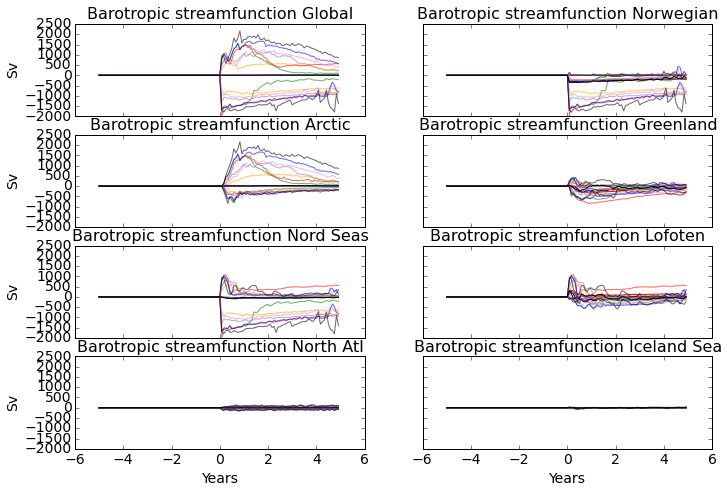

In [33]:
# Plot sea surface elevation per regions
def plot_dynStLayers(dic,row=4,col=2):
    # this function is meant to plot monitor variables
    fig, axes = plt.subplots(row,col,sharex=True,sharey=True)
    for el in dic:
        data_pert = dic[el]["const"] ; data_diff = dic[el]["bench"] 
        grid = grid_read(data_pert.res)
        mask1,mask2,mask3,mask4,mask5,mask6,mask7,mask8 = region_mask(data_pert.res)
        mask0 = np.ones_like(mask1)
        areamasks = {0:mask0 , 1 : mask1 , 2 : mask2 , 3 : mask3, \
                    4 : mask4, 5 : mask5, 6 : mask6, 7: mask7, 8 : mask8}
        region_titles = reg_titles()
        ax_ind = 0
        alphavar = {'mean':1,'max':0.6,'min':0.6}
        for reg in [0,4,1,5,2,6,3,7]:
            maskcalc = np.tile(areamasks[reg][0,:,:],(data_pert.data['Eta'].shape[0],1,1))
            data = np.array(data_pert.psi[:,:,0:data_pert.psi.shape[2]-1])
            data1 = np.array(data_diff.psi)[0:data.shape[0],:,0:data_pert.psi.shape[2]-1]
            datam = (data - data1)*maskcalc            
            datadic = {'mean' : np.nanmean(np.nanmean(datam[:,:,:],axis=2),axis=1) ,
                       'max'  : np.nanmax(np.nanmax(datam[:,:,:],axis=2),axis=1) ,
                       'min'  : np.nanmin(np.nanmin(datam[:,:,:],axis=2),axis=1) }                
            for var in ['mean','max','min']:
                axes.flat[ax_ind].plot(data_diff.years[:]-5,datadic[var][:],color=pert_col[el],
                                      alpha=alphavar[var])
                axes.flat[ax_ind].set_title('Barotropic streamfunction '+region_titles[reg],fontsize=16)
                axes.flat[ax_ind].tick_params(axis='both', which='major', labelsize=14)
                if (ax_ind)%2 == 0:
                    axes.flat[ax_ind].set_ylabel('Sv',fontsize=14)
                axes.flat[6].set_xlabel('Years',fontsize=14)
                axes.flat[7].set_xlabel('Years',fontsize=14)
            ax_ind += 1
    fig.subplots_adjust(right=1.6,top=1.6)
    
    fig.savefig('/noc/users/am8e13/Figures/multipert_psi_reg',dpi=dpires, bbox_inches='tight')

plot_dynStLayers(pert_dic)

# Steric response 

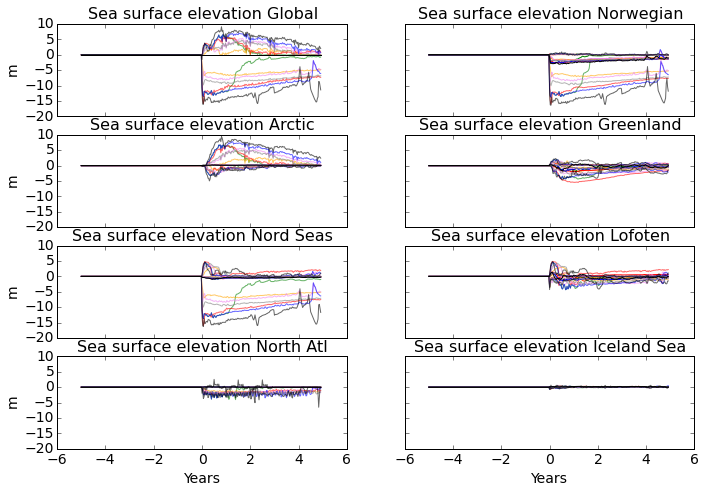

In [34]:
# Plot sea surface elevation per regions
def plot_dynStLayers(dic,row=4,col=2):
    # this function is meant to plot monitor variables   
    fig, axes = plt.subplots(row,col,sharex=True,sharey=True)    
    region_titles = reg_titles()
    var_s = ['eta_mean','eta_min','eta_max']
    vartitles = {'eta_mean' : 'Eta Mean','eta_max' : 'Eta Max','eta_min' : 'Eta Min'}
    alphavar = {'eta_mean':1,'eta_max':0.6,'eta_min':0.6}
    ls_dic = { 36 : '-' , 18 : '--' , 9 : '..' }
    colvar = {'eta_mean':'black','eta_max':'red','eta_min':'blue'}
    for el in dic:
        data_pert = dic[el]["const"] ; data_diff = dic[el]["bench"] 
        ax_ind = 0
        for reg in [0,4,1,5,2,6,3,7]:
            for var in ['eta_mean','eta_max','eta_min']:
                data = data_pert.dataDyn[var][1:10*12*3,reg,0] - data_diff.dataDyn[var][1:10*12*3,reg,0]
                axes.flat[ax_ind].plot(data_diff.dataDyn['time_lv_years'][0:10*12*3-2]-5,data[0:10*12*3-2],color=pert_col[el],
                                      alpha=alphavar[var])
                axes.flat[ax_ind].set_title('Sea surface elevation '+region_titles[reg],fontsize=16)
                if (ax_ind)%2 == 0:
                    axes.flat[ax_ind].set_ylabel('m',fontsize=14)
                axes.flat[6].set_xlabel('Years',fontsize=14)
                axes.flat[7].set_xlabel('Years',fontsize=14)
                axes.flat[ax_ind].tick_params(axis='both', which='major', labelsize=14)

            ax_ind += 1
        fig.subplots_adjust(right=1.6,top=1.6)
    fig.savefig('/noc/users/am8e13/Figures/multipert_ssh_regions',dpi=dpires, bbox_inches='tight')

plot_dynStLayers(pert_dic)

# Fluxes

Most of the flux seems to go through Fram strait, very little through Barents strait or Denmark strait, we check fluxes to confirm this

Fluxes are positives for fluxes into the Arctic

/noc/users/am8e13/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


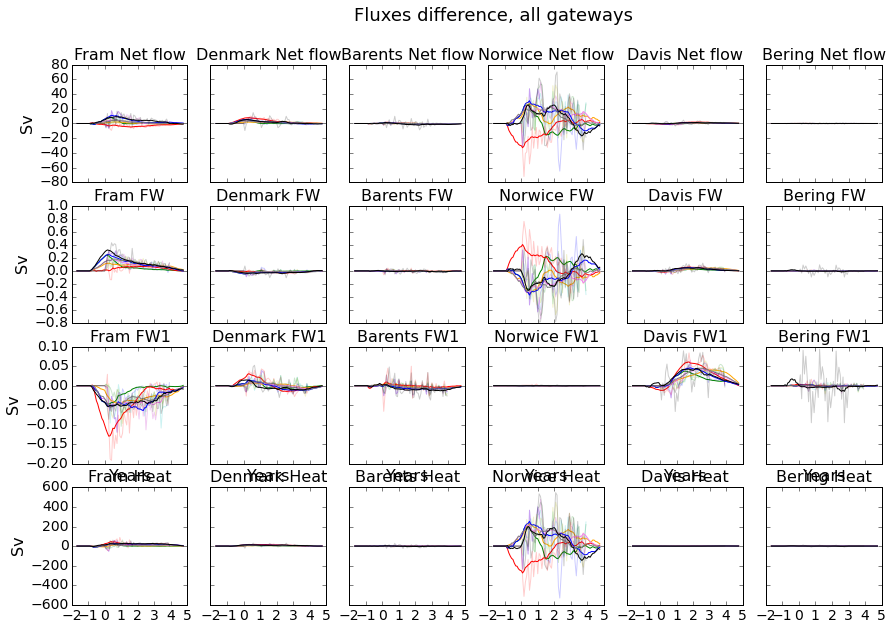

In [35]:
def plot_flux_total_diff(dic):
    # this function is meant to plot monitor variables   
    fluxes = ['FluxSum','FluxSumFW','FluxSumFW1','FluxSumT']#
    variables = ['Fram','Denmark','Barents','Norwice','Davis','Bering']
    #variables = ['Fram','Denmark']
    flux_titles = {'FluxSumFW' : 'FW','FluxSumFW1' : 'FW1','FluxSumS' : 'S', 'FluxSumT':'Heat', \
                   'FluxInSum' : 'Inflow','FluxOutSum' : 'Outflow' , 'FluxSum' : 'Net flow'}
    var_titles = {'Fram' : 'Fram' , 'Fram1' : 'Fram' , 'Fram2' : 'Fram' , 
                  'Davis': 'Davis' , 'Davis1': 'Davis' , 'Davis2': 'Davis',
                 'Denmark' : 'Denmark' , 'Bering' : 'Bering' , 'Norwice' : 'Norwice' ,'Norwice2' : 'Norwice2' ,
                 'Barents' : 'Barents' , 'Barents1' : 'Barents' , 'Barents2' : 'Barents'}
    
    iniz = 40
    fig, axes = plt.subplots(len(fluxes),len(variables),sharex=True,sharey='row')
    for el in dic:
        data_pert = dic[el]["const"] ; data_diff = dic[el]["bench"]
        ax_ind = 0
        for flux in fluxes:
            for var in variables:  
                data = data_pert.fluxes[var][flux]-data_diff.fluxes[var][flux]
                axes.flat[ax_ind].plot(data_diff.years[iniz:-12]-5,data[iniz:-12],alpha=0.2)
                axes.flat[ax_ind].plot(data_diff.years[iniz:-2]-5,runningMeanFast(data,12)[iniz:-2],\
                                       color=pert_col[el])
                axes.flat[ax_ind].set_title(var + flux ,fontsize=16)
                if ax_ind%len(variables)==0:
                    axes.flat[ax_ind].set_ylabel('Sv',fontsize=16)
                if ax_ind/len(variables)==2:
                    axes.flat[ax_ind].set_xlabel('Years',fontsize=16)
                axes.flat[ax_ind].set_title(var_titles[var]+' '+flux_titles[flux],fontsize=16)
                axes.flat[ax_ind].tick_params(axis='both', which='major', labelsize=14)            
                ax_ind += 1
        plt.legend(bbox_to_anchor=(1.05, 1), loc=6, borderaxespad=0.)
    fig.subplots_adjust(right=2.,top=2.)
    fig.suptitle("Fluxes difference, all gateways",x=1.1,y=2.2,fontsize=18)  
    fig.savefig('/noc/users/am8e13/Figures/mixpert_flows_allgate',dpi=dpires, bbox_inches='tight')

plot_flux_total_diff(pert_dic)

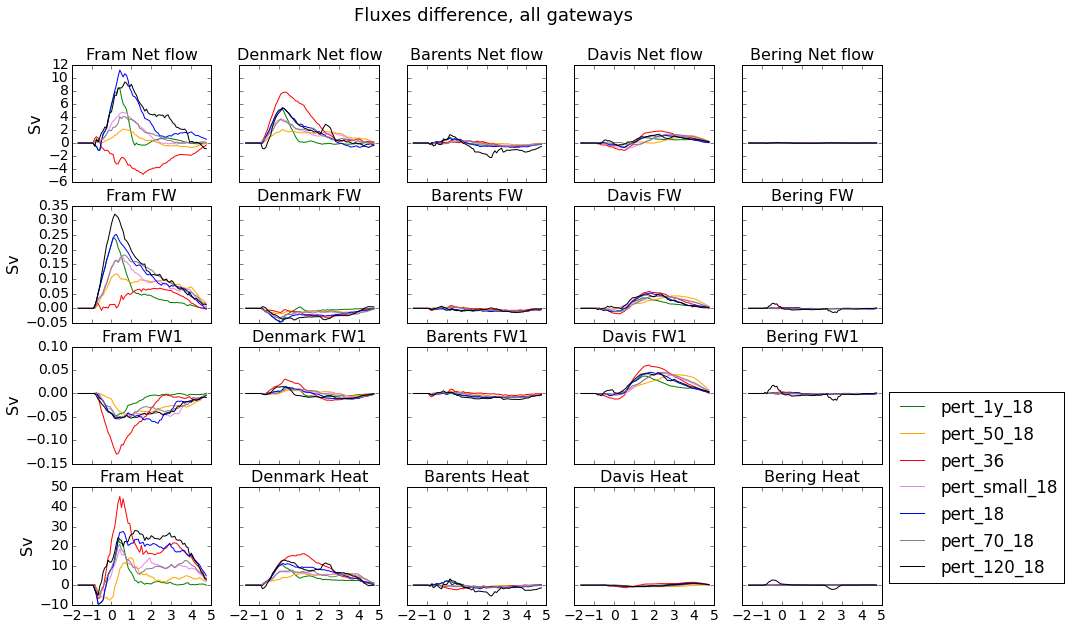

In [36]:
def plot_flux_total_diff(dic):
    # this function is meant to plot monitor variables   
    fluxes = ['FluxSum','FluxSumFW','FluxSumFW1','FluxSumT']#
    variables = ['Fram','Denmark','Barents','Davis','Bering']
    #variables = ['Fram','Denmark']
    flux_titles = {'FluxSumFW' : 'FW','FluxSumFW1' : 'FW1','FluxSumS' : 'S', 'FluxSumT':'Heat', \
                   'FluxInSum' : 'Inflow','FluxOutSum' : 'Outflow' , 'FluxSum' : 'Net flow'}
    var_titles = {'Fram' : 'Fram' , 'Fram1' : 'Fram' , 'Fram2' : 'Fram' , 
                  'Davis': 'Davis' , 'Davis1': 'Davis' , 'Davis2': 'Davis',
                 'Denmark' : 'Denmark' , 'Bering' : 'Bering' , 'Norwice' : 'Norwice' ,'Norwice2' : 'Norwice2' ,
                 'Barents' : 'Barents' , 'Barents1' : 'Barents' , 'Barents2' : 'Barents'}
    
    iniz = 40
    col_dic = {36 : 'blue' , 18 : 'orange' , 9 : 'green'}
    fig, axes = plt.subplots(len(fluxes),len(variables),sharex=True,sharey='row')
    for el in dic:
        data_pert = dic[el]["const"] ; data_diff = dic[el]["bench"]
        ax_ind = 0
        for flux in fluxes:
            for var in variables:  
                data = data_pert.fluxes[var][flux]-data_diff.fluxes[var][flux]
                #axes.flat[ax_ind].plot(data_pert.years[iniz:-12]-5,data[iniz:-12],alpha=0.2)
                axes.flat[ax_ind].plot(data_diff.years[iniz:-2]-5,runningMeanFast(data,12)[iniz:-2],\
                                       color=pert_col[el],label=el)
                axes.flat[ax_ind].set_title(var + flux ,fontsize=16)
                if ax_ind%len(variables)==0:
                    axes.flat[ax_ind].set_ylabel('Sv',fontsize=16)
                #if ax_ind/len(variables)==2:
                    #axes.flat[ax_ind].set_xlabel('Years',fontsize=16)
                axes.flat[ax_ind].set_title(var_titles[var]+' '+flux_titles[flux],fontsize=16)
                axes.flat[ax_ind].tick_params(axis='both', which='major', labelsize=14)            
                ax_ind += 1
        plt.legend(bbox_to_anchor=(1.05, 1), loc=6, borderaxespad=0.)
    fig.subplots_adjust(right=2.,top=2.)
    fig.suptitle("Fluxes difference, all gateways",x=1.1,y=2.2,fontsize=18)  
    fig.savefig('/noc/users/am8e13/Figures/mixpert_flows_allgate',dpi=dpires, bbox_inches='tight')

plot_flux_total_diff(pert_dic)

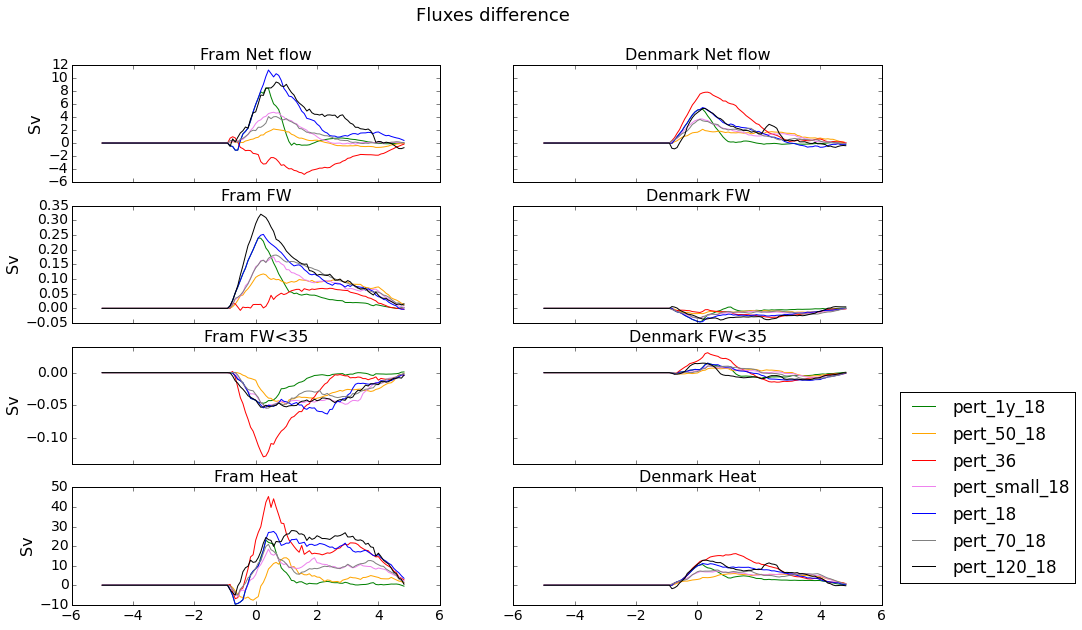

In [37]:
# plot layers
def plot_total_flux(dic,cum=True,row=2,col=2):
    # this function is meant to plot monitor variables   
    
    fluxes = ['Flux','FluxFW','FluxFW1','FluxT']
    #variables = ['Fram','Barents','Davis','Denmark']
    variables = ['Fram','Denmark']
    flux_titles = {'FluxFW' : 'FW','FluxFW1' : 'FW<35','FluxS' : 'S', 'FluxT':'Heat', \
                   'FluxIn' : 'Inflow','FluxOut' : 'Outflow' , 'Flux' : 'Net flow'}
    var_titles = {'Fram' : 'Fram' , 'Fram1' : 'Fram' , 'Fram2' : 'Fram' , 
                  'Davis': 'Davis' , 'Davis1': 'Davis' , 'Davis2': 'Davis',
                 'Denmark' : 'Denmark' , 'Bering' : 'Bering' , 'Norwice' : 'Norwice' ,
                 'Barents' : 'Barents' , 'Barents1' : 'Barents' , 'Barents2' : 'Barents'}
    col_dic = {36 : 'blue' , 18 : 'orange' , 9 : 'green'}
    iniz = 0
    fig, axes = plt.subplots(len(fluxes),len(variables),sharex=True,sharey='row')
    for el in dic:
        ax_ind = 0
        data_pert = dic[el]["const"] ; data_diff = dic[el]["bench"] ;  
        for flux in fluxes:
            for var in variables:
                data = data_pert.fluxes[var][flux]-data_diff.fluxes[var][flux]
                axes.flat[ax_ind].plot(data_diff.years[iniz:-1]-5,runningMeanFast(np.nansum(np.nansum((
                           data)[:,:,:],axis=2),axis=1),12)
                           [iniz:-1],color=pert_col[el],label=el)
                axes.flat[ax_ind].set_title(var + flux ,fontsize=16)
                if ax_ind%len(variables)==0:
                    axes.flat[ax_ind].set_ylabel('Sv',fontsize=16)
                #if ax_ind/len(variables)==2:
                #    axes.flat[ax_ind].set_xlabel('Years',fontsize=16)
                axes.flat[ax_ind].set_title(var_titles[var]+' '+flux_titles[flux],fontsize=16)
                axes.flat[ax_ind].tick_params(axis='both', which='major', labelsize=14)            
                ax_ind += 1
    plt.legend(bbox_to_anchor=(1.05, 1), loc=6, borderaxespad=0.)
    fig.subplots_adjust(right=2.,top=2.)
    fig.suptitle("Fluxes difference",x=1.1,y=2.2,fontsize=18)  
    #fig.savefig('/noc/users/am8e13/Figures/perturbation_davisfram_fluxes'+cumtitle,dpi=dpires, bbox_inches='tight')

plot_total_flux(pert_dic)

# Temperature and salinity evolution

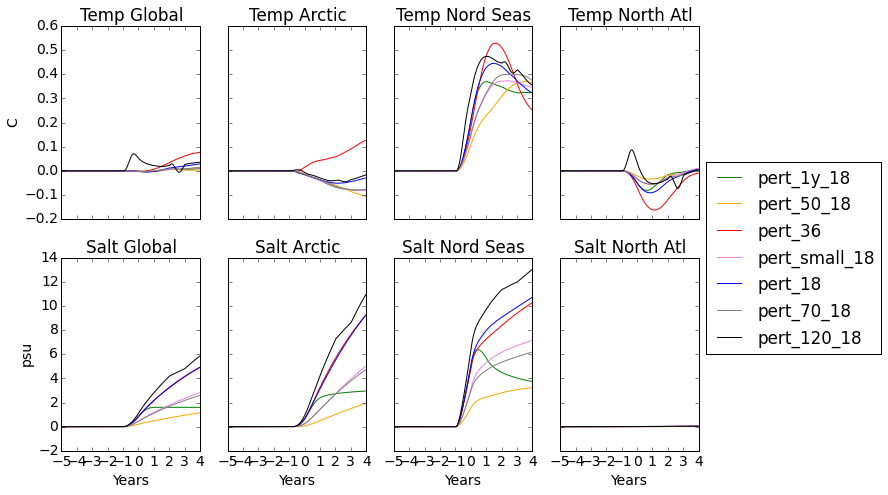

In [49]:
def plot_dynStLayers(dic,row=2,col=4):
    # this function is meant to plot monitor variables  
    col_dic = {36 : 'blue' , 18 : 'orange' , 9 : 'green'}
    region_titles = reg_titles()
    fig, axes = plt.subplots(row,col,sharex=True,sharey='row')
    ax_ind = 0
    var_s = ['theta_mean','salt_mean']
    vartitles = {'theta_mean' : 'Temp', 'salt_mean' : 'Salt'}
    for el in dic:
        ax_ind = 0
        data_pert = dic[el]["const"] ; data_diff = dic[el]["bench"] ;     
        for var in var_s:
            for reg in range(4):
                data = data_pert.dataDyn[var][1:12*10*3,reg,0] - data_diff.dataDyn[var][1:12*10*3,reg,0]
                datam = runningMeanFast(data,12*3)[:-12*3]
                axes.flat[ax_ind].plot(data_diff.dataDyn['time_lv_years'][1:-12*3]-5,\
                                   datam,color=pert_col[el],label=el)
                axes.flat[ax_ind].set_title(vartitles[var]+' '+region_titles[reg])
                axes.flat[0].set_ylabel('C')
                axes.flat[4].set_ylabel('psu')
                axes.flat[4].set_xlabel('Years')
                axes.flat[5].set_xlabel('Years')
                axes.flat[6].set_xlabel('Years')
                axes.flat[7].set_xlabel('Years')
                ax_ind += 1
    plt.legend(bbox_to_anchor=(1.05, 1), loc=6, borderaxespad=0.)
    fig.subplots_adjust(right=1.6,top=1.6)
plot_dynStLayers(pert_dic)

#Freshwater content in Arctic and Nordic Seas

Now we want to study more in the details the changes in freshwater content cause by the perturbation.

Here we consider the freshwater content in the first 1000m of the water column.

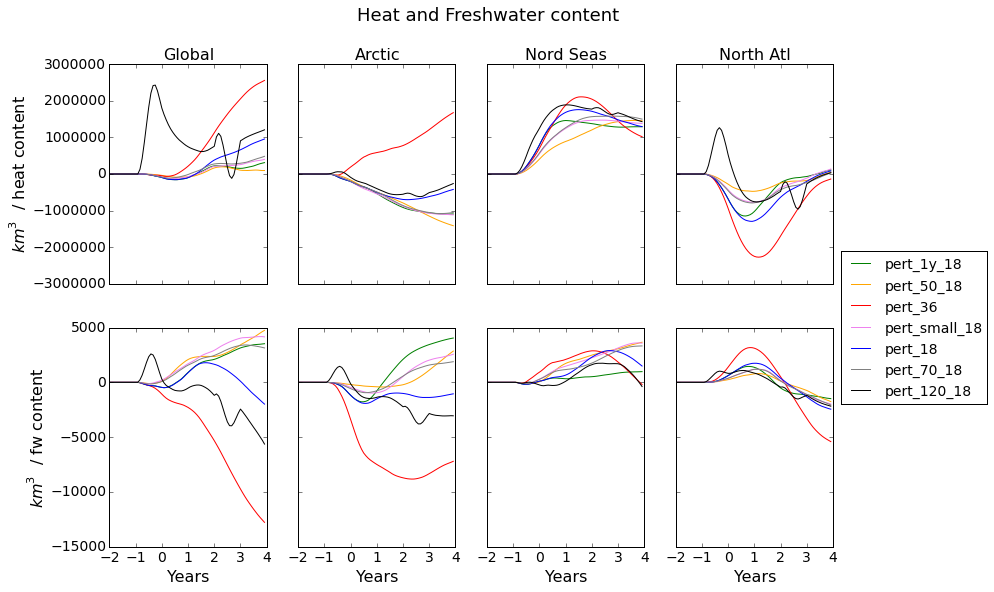

In [50]:
def plot_freshwater_content(dic):
    titles = reg_titles()
    col_dic = {36 : 'blue' , 18 : 'orange' , 9 : 'green'}
    fig , axes = plt.subplots(2,4,sharex=True,sharey='row')

    for el in dic:
        j = 0
        data_pert = dic[el]["const"] ; data_diff = dic[el]["bench"] ;   
        for j in range(4):        
            nt = len(data_pert.freshwater_levels[j,:])
            colormap = matplotlib.cm.jet 
            colors = [colormap(i) for i in np.linspace(0, 1,30)]
            iniz = 36

            datam = np.nansum(data_pert.heat_levels[j,:,0:] - data_diff.heat_levels[j,:nt,0:],axis=1)                
            axes.flat[j].plot(data_diff.years[iniz:-12]-5,runningMeanFast(datam[iniz:],12)[0:-12]/10**9,
                            color=pert_col[el],label=el)  

            datam = np.nansum(data_pert.freshwater_levels[j,:,0:30] - data_diff.freshwater_levels[j,:nt,0:30],axis=1)                
            axes.flat[j+4].plot(data_diff.years[iniz:-12]-5,runningMeanFast(datam[iniz:],12)[0:-12]/10**9,
                            color=pert_col[el],label=el)  
            axes.flat[j].set_title(titles[j],fontsize=16)

            axes.flat[0].set_ylabel(r'$km^3$ / heat content',fontsize=16)
            axes.flat[4].set_ylabel(r'$km^3$ / fw content',fontsize=16)
            axes.flat[j+4].set_xlabel('Years',fontsize=16)
            axes.flat[j].tick_params(axis='both', which='major', labelsize=14)
            axes.flat[j+4].tick_params(axis='both', which='major', labelsize=14)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=6, borderaxespad=0.,fontsize=14)
    fig.suptitle("Heat and Freshwater content ",x=1.,y=2.,fontsize=18)      
    fig.subplots_adjust(right=1.8,top=1.8)
    fig.savefig('/noc/users/am8e13/Figures/mixed_hcfw',dpi=dpires, bbox_inches='tight')

plot_freshwater_content(pert_dic)

# Mixed layer depth

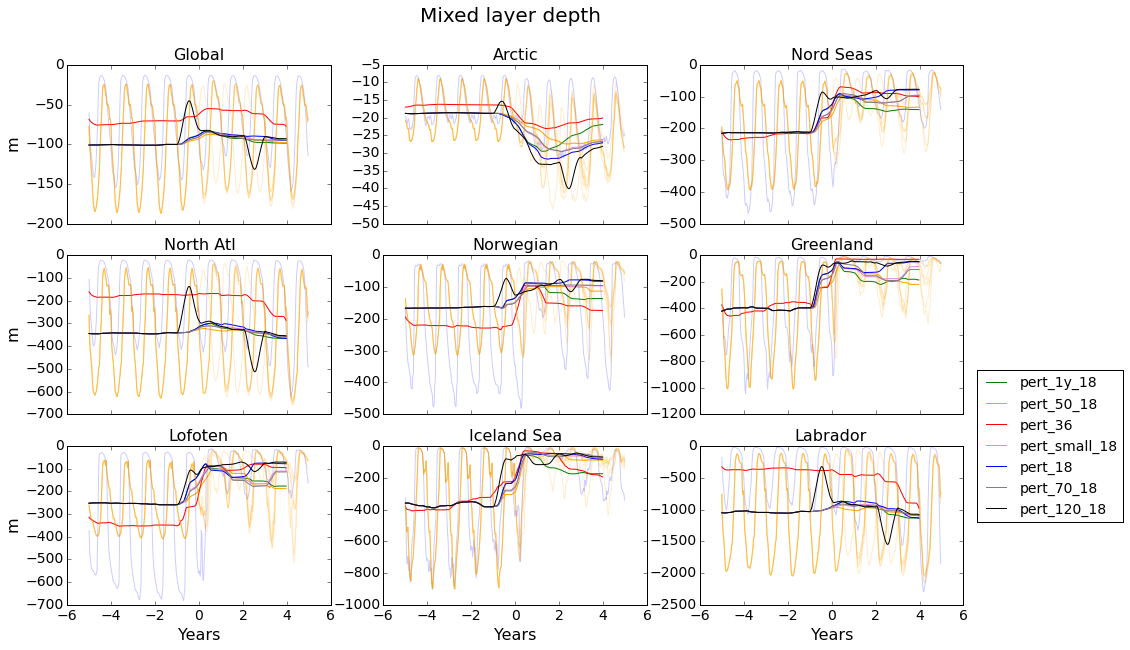

In [52]:
def plot_mxldepth(dic):
    reg_title = reg_titles()
    fig , axes = plt.subplots(3,3,sharey=False,sharex=True)
    col_dic = {36 : 'blue' , 18 : 'orange' , 9 : 'green'}
    for el in dic:
        data_pert = dic[el]["const"] ; data_diff = dic[el]["bench"] ; 
        for j in range(len(reg_title)):
            data = data_pert.mxldepth_mean[j] #- data_diff.mxldepth_mean[j]
            axes.flat[j].plot(data_diff.mxldepth_years-5,-data,alpha=0.2,color=col_dic[data_pert.res])
            axes.flat[j].plot(data_diff.mxldepth_years[0:-12*3]-5,-runningMeanFast(data,12*3)[0:-12*3],\
                              color=pert_col[el],label=el)
            axes.flat[j].set_title(reg_title[j],fontsize=16)   
        axes.flat[6].set_xlabel('Years',fontsize=16)
        axes.flat[7].set_xlabel('Years',fontsize=16)
        axes.flat[8].set_xlabel('Years',fontsize=16)
        axes.flat[0].set_ylabel('m',fontsize=16)
        axes.flat[3].set_ylabel('m',fontsize=16)
        axes.flat[6].set_ylabel('m',fontsize=16)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=6, borderaxespad=0.,fontsize=14)
    fig.subplots_adjust(right=2.2,top=2.)
    fig.suptitle("Mixed layer depth",x=1.15,y=2.2,fontsize=20)
    fig.savefig('/noc/users/am8e13/Figures/mixed_mxldepth_diag',dpi=dpires, bbox_inches='tight')

plot_mxldepth(pert_dic)

# Seaice

We look at the seaice to see if the excess in freshwater could be caused by a decrease in seaice

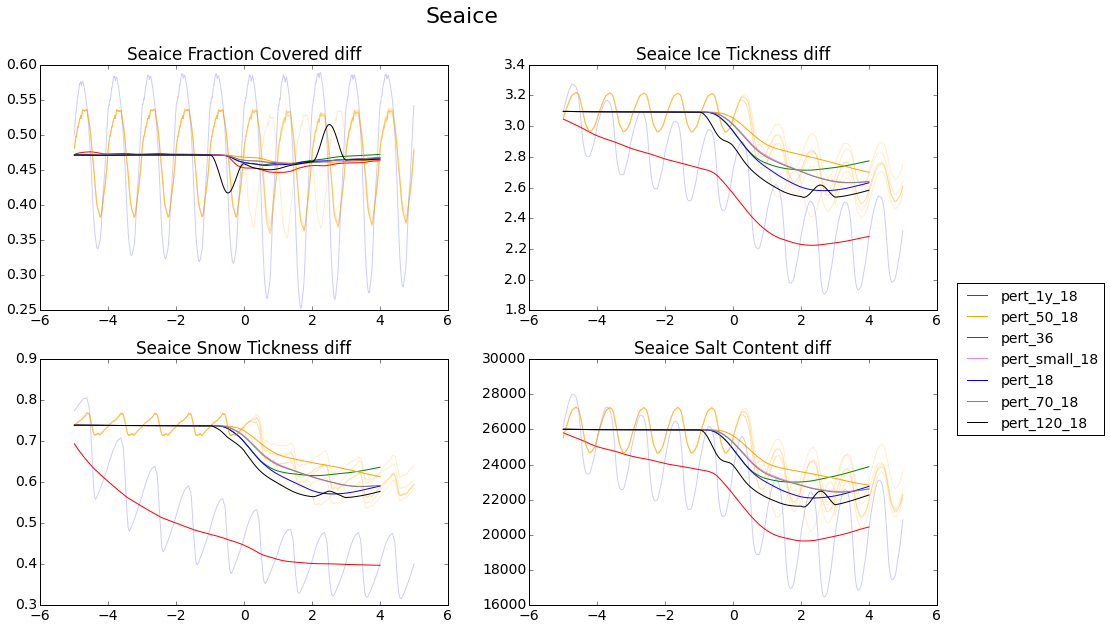

In [53]:
def plot_seaice(dic):
    variables = ['seaice_area_mean' , 'seaice_heff_mean','seaice_hsnow_mean','seaice_hsalt_mean']
    titles = {'seaice_area_mean' : 'Seaice Fraction Covered', 'seaice_heff_mean' : 'Seaice Ice Tickness',
              'seaice_hsnow_mean' : 'Seaice Snow Tickness', 'seaice_hsalt_mean' : 'Seaice Salt Content'}
    fig , axes = plt.subplots(2,2)
    col_dic = {36 : 'blue' , 18 : 'orange' , 9 : 'green'}
    for el in dic:
        data_pert = dic[el]["const"] ; data_diff = dic[el]["bench"] ;     
        nt = len(data_diff.data['time_years_ice'])
        for j in range(4):  
            data = data_pert.data[variables[j]][0:nt] #- data_diff.data[variables[j]][0:nt]        
            axes.flat[j].plot(data_diff.data['time_years_ice']-5,data,alpha=0.2,\
                              color=col_dic[data_pert.res])
            axes.flat[j].plot(data_diff.data['time_years_ice'][0:-360]-5,runningMeanFast(data,360)[0:-360],\
                             color=pert_col[el],label=el)
            axes.flat[j].set_title(titles[variables[j]]+' diff')  
    plt.legend(bbox_to_anchor=(1.05, 1), loc=6, borderaxespad=0.,fontsize=14)
    fig.suptitle('Seaice',x=1.1,y=2.2,fontsize=22)
    fig.subplots_adjust(right=2.2,top=2.)
    fig.savefig('/noc/users/am8e13/Figures/mixed_seiace_diag',dpi=dpires, bbox_inches='tight')
plot_seaice(pert_dic)

# Overflow calculation

In [57]:
def fluxesCalculation(run):
    kdic = {36:1,18:2,9:4}
    kk = kdic[run.res]

    file2read = netcdf.NetCDFFile('/scratch/general/am8e13/results'+str(run.res)+'km/grid.nc','r')
    hfacc = file2read.variables['HFacC']
    hfacc = hfacc[:]*1
    drf = file2read.variables['drF']
    drf = drf[:]*1
    rA = file2read.variables['rA']
    rA = rA[:]*1
    dyF = file2read.variables['dyF']
    dyF = dyF[:]*1
    dxF = file2read.variables['dxF']
    dxF = dxF[:]*1
    dydx = np.zeros_like(hfacc)
    for k in range(len(drf)):
        dydx[k,:,:] = drf[k]*rA*hfacc[k,:,:]
    Area_x = dydx/dxF
    Area_y = dydx/dyF
    Area_x[hfacc==0]=np.nan
    Area_y[hfacc==0]=np.nan
    
    coords = {}
    coords = {'Fram': [58,80,76,76], 'Fram1' : [55,85,78,78] , 'Fram2' : [60,83,72,72] , 'Denmark': [100,100,37,48] , \
             'Bering' : [80,89,178,178] , 'Davis' : [113,135,75,75] , 'Davis1' : [135,135,52,73] , 'Davis2' : [113,135,75,75]}
    ax_d = {'Fram': 3, 'Fram1' : 3 , 'Fram2' : 3 , 'Denmark': 2 , 'Bering' : 3 , 'Davis' : 3 , 'Davis1' : 2 , 'Davis2' : 3}
    vel = {'Fram': 'U', 'Fram1' : 'V' , 'Fram2' : 'V' , 'Denmark': 'U' , \
             'Bering' : 'V' , 'Davis' : 'U' , 'Davis1' : 'U' , 'Davis2' : 'U' }
    
    def coord_calc(coord):
        if coord[0] == coord[1]:
            coord[0] = coord[0]*kk
            coord[1] = coord[0]+1
            coord[2] = coord[2]*kk
            coord[3] = coord[3]*kk
        elif coord[2] == coord[3]:
            coord[0] = coord[0]*kk
            coord[1] = coord[1]*kk
            coord[2] = coord[2]*kk
            coord[3] = coord[2]+1
        return coord

    run.fluxes2 = {}
    for var in ['Fram','Fram1','Fram2','Denmark','Bering','Davis','Davis1','Davis2']:
        coord = coords[var]
        coord = coord_calc(coord)
        run.fluxes2[var] = {'Flux' : np.zeros_like(run.data[vel[var]][:,:,coord[0]:coord[1],coord[2]:coord[3]]),\
                            'FluxSum' : np.zeros_like(run.data[vel[var]][:,0,0,0]),\
                            'FluxInSum' : np.zeros_like(run.data[vel[var]][:,0,0,0]),\
                            'FluxOutSum' : np.zeros_like(run.data[vel[var]][:,0,0,0]),\
                            'FluxS' : np.zeros_like(run.data['S'][:,:,coord[0]:coord[1],coord[2]:coord[3]]),\
                            'FluxSumS' : np.zeros_like(run.data['S'][:,0,0,0]),\
                            'FluxT' : np.zeros_like(run.data['T'][:,:,coord[0]:coord[1],coord[2]:coord[3]]),\
                            'FluxSumT' : np.zeros_like(run.data['T'][:,0,0,0]),\
                            'FluxFW' : np.zeros_like(run.data['T'][:,:,coord[0]:coord[1],coord[2]:coord[3]]),\
                            'FluxSumFW' : np.zeros_like(run.data['T'][:,0,0,0]),\
                            'FluxFW1' : np.zeros_like(run.data['T'][:,:,coord[0]:coord[1],coord[2]:coord[3]]),\
                            'FluxSumFW1' : np.zeros_like(run.data['T'][:,0,0,0]),\
                            'FluxTop' : [], 'FluxMid' : [] , 'FluxBot' : [], \
                            'FluxTopS' : [], 'FluxMidS' : [] , 'FluxBotS' : [], \
                            'FluxTopT' : [], 'FluxMidT' : [] , 'FluxBotT' : []}
        
    S0 = 34.8 # reference salinity
    # this is to calculate the FW flux correctly
    tmp = np.ones_like(run.data['S'])
    tmp[:,31:,:,:] = 0

    # this is to calculate the FW flux correctly
    tmp1 = np.ones_like(run.data['S'])
    tmp1[run.data['S']>S0] = 0
    for var in ['Fram','Fram1','Fram2','Denmark','Bering','Davis','Davis1','Davis2']:
        coord = coords[var]
        coord = coord_calc(coord)
        for t in range(run.data['V'].shape[0]):    
            # Fram fillign
            run.fluxes2[var]['Flux'][t,:,:] = run.data[vel[var]][t,:,coord[0]:coord[1],coord[2]:coord[3]]*\
                    Area_y[:,coord[0]:coord[1],coord[2]:coord[3]]/10**6
            run.fluxes2[var]['FluxSum'][t] = np.nansum(np.nansum(run.fluxes2[var]['Flux'][t,:,:]))
            run.fluxes2[var]['FluxInSum'][t] = np.nansum(np.nansum(run.fluxes2[var]['Flux'][t,run.fluxes2[var]['Flux'][t,:,:]>0]))
            run.fluxes2[var]['FluxOutSum'][t] = np.nansum(np.nansum(run.fluxes2[var]['Flux'][t,run.fluxes2[var]['Flux'][t,:,:]<0]))
            run.fluxes2[var]['FluxT'][t,:,:] = run.fluxes2[var]['Flux'][t,:,:]*\
                                                run.data['T'][t,:,coord[0]:coord[1],coord[2]:coord[3]]
            run.fluxes2[var]['FluxSumT'][t] = np.nansum(np.nansum(run.fluxes2[var]['FluxT'][t,:,:]))
            run.fluxes2[var]['FluxS'][t,:,:] = run.fluxes2[var]['Flux'][t,:,:]*\
                                                run.data['S'][t,:,coord[0]:coord[1],coord[2]:coord[3]]
            run.fluxes2[var]['FluxSumS'][t] = np.nansum(np.nansum(run.fluxes2[var]['FluxS'][t,:,:])) 
            run.fluxes2[var]['FluxFW'][t,:,:] = run.fluxes2[var]['Flux'][t,:,:]*\
                    (1 - run.data['S'][t,:,coord[0]:coord[1],coord[2]:coord[3]]/S0)*tmp[t,:,coord[0]:coord[1],coord[2]:coord[3]]
            run.fluxes2[var]['FluxSumFW'][t] = np.nansum(np.nansum(run.fluxes2[var]['FluxFW'][t,:,:]))                 
            run.fluxes2[var]['FluxFW1'][t,:,:] = run.fluxes2[var]['Flux'][t,:,:]*\
                    (1 - run.data['S'][t,:,coord[0]:coord[1],coord[2]:coord[3]]/S0)*tmp1[t,:,coord[0]:coord[1],coord[2]:coord[3]]
            run.fluxes2[var]['FluxSumFW1'][t] = np.nansum(np.nansum(run.fluxes2[var]['FluxFW1'][t,:,:]))   
        
        for flux in ['Flux','FluxT','FluxS','FluxFW','FluxFW1']:
            run.fluxes2[var][flux] = np.squeeze(run.fluxes2[var][flux],axis=ax_d[var])
            
    print run.title +' flux calculated'


fluxesCalculation(pert_120_18)
fluxesCalculation(pert_70_18)
fluxesCalculation(pert_50_18)
fluxesCalculation(pert_1y_18)
fluxesCalculation(pert_bench_18)
fluxesCalculation(pert_bench_36)
fluxesCalculation(pert_const_18)
fluxesCalculation(pert_const_36)
fluxesCalculation(pert_small_18)

Const restoring flux calculated
Const restoring flux calculated
Const restoring flux calculated
Const restoring flux calculated
No restoring flux calculated
No restoring flux calculated
Const restoring flux calculated
Const restoring flux calculated
Const restoring flux calculated


In [58]:
# calculation of denmark overflow
def density_calc(run):
    run.data['rho_jmd'] = np.zeros_like(run.data['S'])
    run.data['rhop'] = np.zeros_like(run.data['S'])
    for t in range(run.data['S'].shape[0]):
        for z in range(len(run.Z)):
            run.data['rho_jmd'][t,z,:,:] = densjmd95(run.data['S'][t,z,:,:],run.data['T'][t,z,:,:],-9.81*run.Z[z]*1025)
        run.data['rhop'][t,:,:,:] = rhop(run.data['S'][t,:,:,:],run.data['T'][t,:,:,:])
        
    print run.title +' density calculated'


density_calc(pert_120_18)
density_calc(pert_70_18)
density_calc(pert_50_18)
density_calc(pert_1y_18)
density_calc(pert_bench_18)
density_calc(pert_bench_36)
density_calc(pert_const_18)
density_calc(pert_const_36)
density_calc(pert_small_18)

Const restoring density calculated
Const restoring density calculated
Const restoring density calculated
Const restoring density calculated
No restoring density calculated
No restoring density calculated
Const restoring density calculated
Const restoring density calculated
Const restoring density calculated


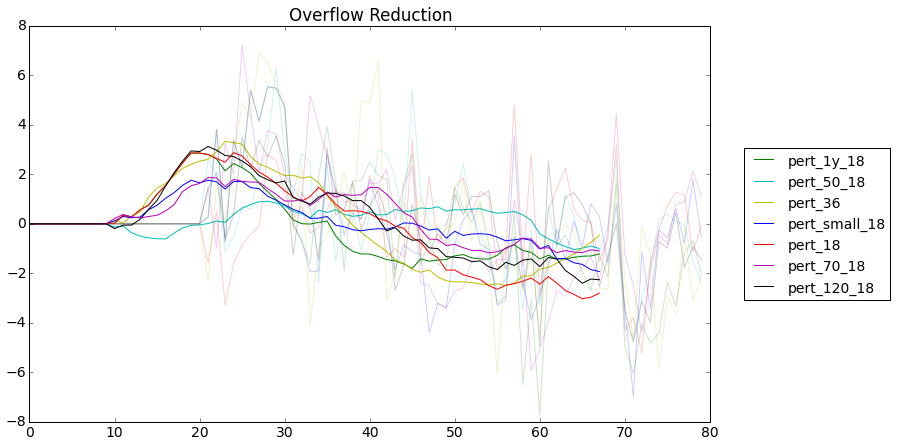

In [59]:
def plot_overflow(dic):
    rho0 = 1027.8
    var = 'Flux' 
    fig , axes = plt.subplots(1,1,sharey=False,sharex=True)
    for el in dic:  
        kdic = {36:1,18:2,9:4}
        kk = kdic[dic[el]['const'].res]
        data = (dic[el]['const'].fluxes2['Denmark'][var])*(dic[el]['const'].data['rhop'][:,:,100*kk,37*kk:48*kk]>rho0) - \
                (dic[el]['bench'].fluxes2['Denmark'][var])*(dic[el]['bench'].data['rhop'][:,:,100*kk,37*kk:48*kk]>rho0)
        datam = np.nansum(np.nansum(data,axis=1),axis=1)
        plt.plot(-datam[40:],alpha=0.2)
        toplot = runningMeanFast(datam,12)[0:-12]
        plt.plot(-toplot[40:],label=el)
    plt.title('Overflow Reduction')
    plt.legend(bbox_to_anchor=(1.05,0.5), loc=6, borderaxespad=0.,fontsize=14)    
    fig.subplots_adjust(right=1.7,top=1.5)
plot_overflow(pert_dic)

In [ ]:
def plot_mxldepth(dic):
    reg_title = reg_titles()
    fig , axes = plt.subplots(3,3,sharey=False,sharex=True)
    col_dic = {36 : 'blue' , 18 : 'orange' , 9 : 'green'}
    for el in dic:
        data_pert = dic[el]["const"] ; data_diff = dic[el]["bench"] ; 
        for j in range(len(reg_title)):
            data = data_pert.mxldepth_mean[j]
            axes.flat[j].plot(data_pert.mxldepth_years-5,-data,alpha=0.2,color=col_dic[data_pert.res])
            axes.flat[j].plot(data_pert.mxldepth_years[0:-12*3]-5,-runningMeanFast(data,12*3)[0:-12*3],\
                              color=pert_col[el],label=el)
            axes.flat[j].set_title(reg_title[j],fontsize=16)   
        axes.flat[6].set_xlabel('Years',fontsize=16)
        axes.flat[7].set_xlabel('Years',fontsize=16)
        axes.flat[8].set_xlabel('Years',fontsize=16)
        axes.flat[0].set_ylabel('m',fontsize=16)
        axes.flat[3].set_ylabel('m',fontsize=16)
        axes.flat[6].set_ylabel('m',fontsize=16)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=6, borderaxespad=0.,fontsize=14)
    fig.subplots_adjust(right=2.2,top=2.)
    fig.suptitle("Mixed layer depth",x=1.15,y=2.2,fontsize=20)
    fig.savefig('/noc/users/am8e13/Figures/mixed_mxldepth_diag',dpi=dpires, bbox_inches='tight')

plot_mxldepth(pert_dic)

In [63]:
1728*600/float(60*60*36*24)

0.3333333333333333

In [65]:
5927040 - 5978880


-51840

In [66]:
for j in range(7):
    print 6030720 + j*51840

6030720
6082560
6134400
6186240
6238080
6289920
6341760
